# X-Ray Generation

In this project, you'll define and train a DCGAN on a dataset of xray images. Your goal is to get a generator network to generate *new* images that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic images with small amounts of noise.

### Get the Data

You'll be using a dataset provided by the instructor to train your adversarial networks.

You should prepare to define deeper networks and train them for a long time to get good results. It is suggested that you utilize the CPU with few epochs (and maybe smaller images) to make sure your model is making progress. But for ther actual training it is suggested that you use a GPU.

### The Data

Some sample from real data is show below.

<img src='https://lh4.googleusercontent.com/WuKslIcpRUteJZ7rYF2rQiqdNT_Ot83ZXSnQNntfYZEpoHKcpWv_kOtIrQPx9rHWBwBPTzBGQCtv-AtJXDBGn2M' width=100% />

And now, the kind of images your model must be able to create.

<img src='https://lh3.googleusercontent.com/O06afKIwX-pPXzvflt8mqHGWFqo10MrcbcRaY64Dv54Yu70CZQrP6q81Z0qsSCMxHMI5rkRpB2bC3hvDdEX0VkQ' width=100%>

These synthetic data, created from a simple model, are far from perfect. But some of them may pass as real for someone not used to chest x-ray images.

In [42]:
from os.path import exists

if not exists('data.zip'):
  !gdown 1A7_vb_XAOMCKJ83L2furotEz2uLMERex
else:
  print('Download ok!')
if not exists('data/0'):
  !unzip data.zip
else:
  print('Unzip ok!')

Download ok!
Unzip ok!


In [43]:
data_dir = 'data/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Visualize the CelebA Data

Albeit clearly representing greyscale images, note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each. However, check and see if you need all of those channels.

### Pre-process and Load the Data

There are a few other steps that you'll need to **transform** this data and create a **DataLoader**. If you observe the data, you will notice the images have different shapes.

Also, albeit clearly representing greyscale images, note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each. Change the data so only one channel is used.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Drop 2 channels so the dataloader returns a tensor with dimensions `[B,1,image_size,image_size]`. I suggest using the [Lambda transform](https://pytorch.org/vision/stable/transforms.html)
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `data/` and data transformation passed in.

In [44]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [45]:
%%html
<h1 style='color: red; font-size: 19pt'><b>1. Parte da atividade na próxima célula</b></h1>

In [46]:
def get_dataloader(batch_size, image_size, data_dir='./data/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    data_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((image_size,image_size)),
                                     transforms.CenterCrop(image_size),
                                     transforms.Grayscale(1)
                                    ])

    train_data = datasets.ImageFolder(data_dir, transform=data_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, 
                                           num_workers=0, shuffle=True)
    # TODO: Implement function and return a dataloader     
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `64`. Resizing the data to a smaller size will make for faster training, while still creating convincing x-ray images!

In [47]:
%%html
<h1 style='color: red; font-size: 19pt'><b>2. Parte da atividade na próxima célula</b></h1>

In [48]:
# Define function hyperparameters
batch_size = 20
img_size = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered x-rays.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

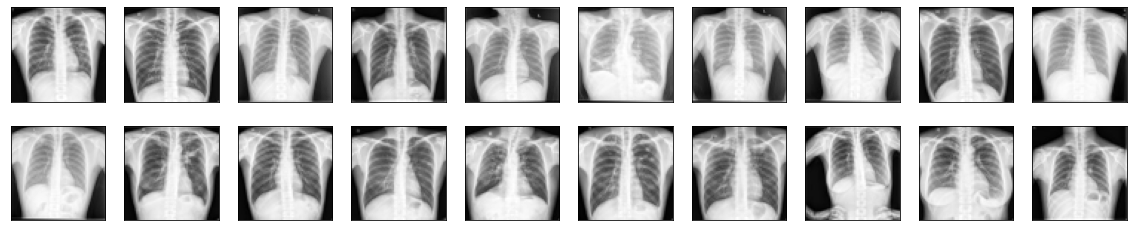

In [49]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.squeeze(np.transpose(npimg, (1, 2, 0))),cmap='gray')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [50]:
%%html
<h1 style='color: red; font-size: 19pt'><b>3. Parte da atividade na próxima célula</b></h1>

In [51]:
# TODO: Complete the scale function
def scale(x, feature_range = (-1,1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''

    X_scaled = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    return X_scaled


In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[8]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())



Min:  tensor(-0.9098)
Max:  tensor(0.8626)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/661c38e1c6a1f6734c26ecd899b958533c41cf1f/dcgan-svhn/assets/conv_discriminator.png">

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 64x64x1 tensor images. The model above expects a different image. Adapt the model above accordingly with our image specifications.
* The output should be a single value that will indicate whether a given image is real or fake


In [53]:
import torch.nn as nn
import torch.nn.functional as F

In [54]:
%%html
<h1 style='color: red; font-size: 19pt'><b>4. Parte da atividade na próxima célula</b></h1>

In [55]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
 ## encoder layers ##

        self.conv = nn.Sequential(
            nn.Conv2d(1, conv_dim, 2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(conv_dim),
            nn.Dropout(0.3),
            nn.Conv2d(conv_dim, conv_dim*2, 2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(conv_dim*2),
            nn.Dropout(0.3),
            nn.Conv2d(conv_dim*2, conv_dim*4, 2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(conv_dim*4),
            nn.Dropout(0.3),
            nn.Conv2d(conv_dim*4, conv_dim*8, 2, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(conv_dim*8),
            nn.Dropout(0.3),
        )

        self.fc = nn.Sequential(
            nn.Linear(conv_dim*8 * 4 * 4, conv_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(conv_dim*8, conv_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(conv_dim*4, int(conv_dim/4)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
        )
        self.out = nn.Sequential(
            nn.Linear(int(conv_dim/4), 1),
            nn.Sigmoid()

        )

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after

        x = self.conv(x)
        x = x.view(-1, 512 * 4 * 4)
        x = self.fc(x)
        x = self.out(x)
        
        return x

In [56]:
Discriminator()

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3, inpla

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `64x64x1`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

<img src="https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/661c38e1c6a1f6734c26ecd899b958533c41cf1f/dcgan-svhn/assets/conv_generator.png">

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `64x64x1`. The model above creates a different image. Adapt the model above accordingly with our image specifications.

In [57]:
%%html
<h1 style='color: red; font-size: 19pt'><b>5. Parte da atividade na próxima célula</b></h1>

In [58]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv = nn.Sequential(
            nn.BatchNorm2d(conv_dim*8),
            nn.ConvTranspose2d(conv_dim*8, conv_dim*4, 2, 2),
            #nn.ReLU(),
            #nn.BatchNorm2d(conv_dim*4),
            #nn.Dropout(0.3),
            nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(conv_dim*2),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(conv_dim*2, conv_dim, 2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(conv_dim),
            nn.Dropout(0.3),
            
        )

        self.fc = nn.Sequential(
            nn.Linear(z_size, conv_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(conv_dim, conv_dim*8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(conv_dim*8, conv_dim*128),
            nn.BatchNorm1d(conv_dim*128)
            #nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.Linear(conv_dim*32, conv_dim*128),
            #nn.ReLU(),
            #nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            nn.ConvTranspose2d(conv_dim, 1, 2, 2),
            nn.Tanh()
        )
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        aux = x.shape[0]
        x = self.fc(x)
        x = torch.reshape(x, (aux, 512 , 4 , 4))
        x = self.conv(x)
        x = self.out(x)
        
        return x

In [59]:
Generator(120,64)

Generator(
  (conv): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU(inplace=True)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.3, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=120, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=8192, bias=True)
    (7): Bat

## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You should consult the [pytorch documentation](https://pytorch.org/docs/stable/nn.init.html) at this time

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [60]:
%%html
<h1 style='color: red; font-size: 19pt'><b>6. Parte da atividade na próxima célula</b></h1>

In [61]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    #@torch.no_grad()
    if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
                nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    # TODO: Apply initial weights to convolutional and linear layers
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [63]:
%%html
<h1 style='color: red; font-size: 19pt'><b>7. Parte da atividade na próxima célula</b></h1>

In [64]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.3, inpla

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [66]:
%%html
<h1 style='color: red; font-size: 19pt'><b>8. Parte da atividade na próxima célula</b></h1>

In [67]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    if train_on_gpu:
      labels = labels.cuda()
    # numerically stable loss
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):

    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
      labels = labels.cuda()
    criterion = nn.BCELoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [68]:
%%html
<h1 style='color: red; font-size: 19pt'><b>9. Parte da atividade na próxima célula</b></h1>

In [69]:
import torch.optim as optim
lr = 0.0002

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, (0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr, (0.5, 0.999))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [70]:
%%html
<h1 style='color: red; font-size: 19pt'><b>10. Parte da atividade na próxima célula</b></h1>

In [71]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
              real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, True)
        
        # 2. Train with fake images
        
        # Generate fake images
        # gradients don't have to flow during this step
            with torch.no_grad():
              y = np.random.uniform(-1, 1, size=(batch_size, z_size))
              y = torch.from_numpy(y).float()
              if train_on_gpu:
                y = y.cuda()
              fake_images = G(y)
        
        # Compute the discriminator losses on fake images        
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
              z = z.cuda()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [72]:
%%html
<h1 style='color: red; font-size: 19pt'><b>11. Parte da atividade na próxima célula</b></h1>

In [73]:
# set number of epochs 
n_epochs = 150 # 50 epochs or higher


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  150] | d_loss: 1.3937 | g_loss: 0.6608
Epoch [    2/  150] | d_loss: 0.8840 | g_loss: 0.9185
Epoch [    3/  150] | d_loss: 0.4665 | g_loss: 2.3479
Epoch [    4/  150] | d_loss: 0.4141 | g_loss: 3.9385
Epoch [    5/  150] | d_loss: 0.3508 | g_loss: 4.9020
Epoch [    6/  150] | d_loss: 0.3587 | g_loss: 6.0381
Epoch [    7/  150] | d_loss: 0.3494 | g_loss: 6.9122
Epoch [    8/  150] | d_loss: 0.3383 | g_loss: 7.3609
Epoch [    9/  150] | d_loss: 0.3429 | g_loss: 7.8958
Epoch [   10/  150] | d_loss: 0.3372 | g_loss: 9.0094
Epoch [   11/  150] | d_loss: 0.3415 | g_loss: 9.2855
Epoch [   12/  150] | d_loss: 0.3801 | g_loss: 7.7620
Epoch [   13/  150] | d_loss: 0.4071 | g_loss: 3.9630
Epoch [   14/  150] | d_loss: 0.9950 | g_loss: 1.4318
Epoch [   15/  150] | d_loss: 0.6199 | g_loss: 7.6446
Epoch [   16/  150] | d_loss: 0.7921 | g_loss: 5.5875
Epoch [   17/  150] | d_loss: 0.5299 | g_loss: 5.3237
Epoch [   18/  150] | d_loss: 0.6247 | g_loss: 5.5617
Epoch [   19/  150] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

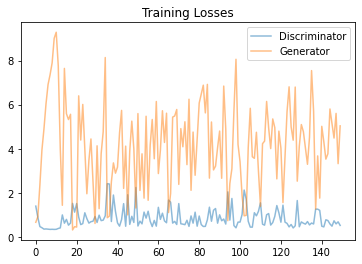

In [74]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, after the first and the last epoch

In [75]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        #print(img.shape)
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((img_size,img_size)),cmap='gray')

In [76]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [77]:
%%html
<h1 style='color: red; font-size: 19pt'><b>12. Parte da atividade nas próximas célula</b></h1>

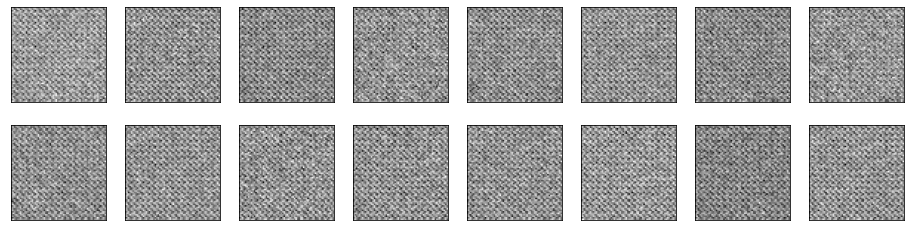

In [78]:
#show samples after the first epoch
view_samples(1, samples)

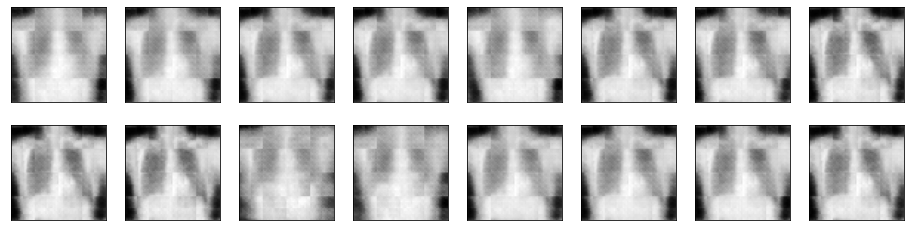

In [79]:
#show samples after halfway through the training
view_samples(round((n_epochs/2))+1, samples)

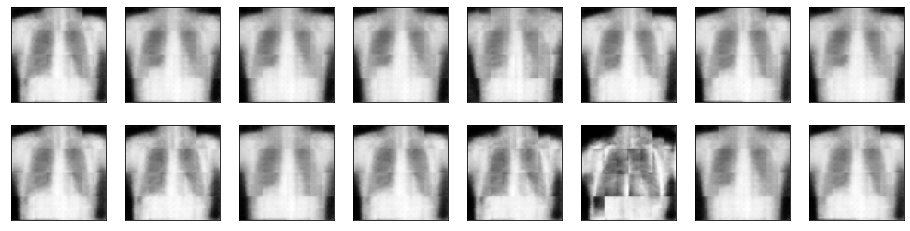

In [80]:
#show samples after the last epoch
view_samples(-1, samples)

In [81]:
%%html
<h1 style='color: red; font-size: 19pt'><b>13. Parte da atividade na próxima célula</b></h1>

In [82]:
# generate 16 images that the discriminator see as a real image, i.e. the sigmoid of the output higher than 0.55 (or you may choose a higher threshold)

# show those images (2 rows x 8 columns)